# ¿Cómo puedo comparar diferentes modelos que predicen la probabilidad de incumplimiento de un préstamo?

In [13]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

## Introduction (5 mts)

**Contexto comercial.** Los bancos comerciales tradicionales generalmente no confiaban en modelos estadísticos para decidir si se debían emitir préstamos personales, aunque esto está cambiando rápidamente hoy en día. Usted es un científico de datos que trabaja en un banco comercial moderno. Su equipo de ciencia de datos ya ha creado modelos de regresión simples para predecir la probabilidad de incumplimiento de esos préstamos. Sin embargo, ha notado que muchos de estos modelos funcionan mucho peor en producción que en pruebas.

**Problema empresarial.** Su tarea es **construir un modelo de probabilidad predeterminado que se sienta cómodo poner en producción.**


**Contexto analítico.** El conjunto de datos contiene los detalles de 5000 solicitudes de préstamos emitidas previamente por su banco. Para cada préstamo, el estado final del préstamo (es decir, si el préstamo está en incumplimiento) también está disponible:


1. El archivo **"loan_light.csv"** contiene los detalles de 5000 préstamos
2. El archivo **"loan_param.xlsx"** contiene la descripción de cada covariable

El caso procederá de la siguiente manera: 
1. Realizará una exploración de datos para determinar las transformaciones de variables apropiadas para realizar
2. Se ajustan a algunos modelos simples; 
3. Aprender sobre **validación cruzada** y usar esto para seleccionar el mejor modelo simple; y finalmente 
4. Construir responsablemente modelos más complejos usando validación cruzada.

## Exploración de datos

Comencemos por echar un vistazo a los datos:

In [14]:
Data = pd.read_csv("loan_light.csv")
Data = Data.sample(frac=1)  #shuffle the rows

In [15]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
882,26000.0,Individual,5751.0,0.0,0.0,33.80,1,D,2.0,324.85,...,1.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,0,cook
4031,181000.0,Individual,12867.0,0.0,1.0,13.07,10,B,1.0,781.04,...,2.0,0.0,RENT,36,2.0,1.0,credit_card,2016,0,other
4241,53000.0,Individual,16697.0,0.0,0.0,24.46,10,C,2.0,905.58,...,5.0,0.0,MORTGAGE,36,2.0,0.0,debt_consolidation,2016,0,teacher
3040,95000.0,Individual,4957.0,0.0,0.0,17.01,10,B,5.0,32.97,...,3.0,1.0,RENT,36,0.0,0.0,other,2016,0,supervisor
4178,95000.0,Individual,25969.0,0.0,0.0,17.64,10,C,4.0,395.02,...,5.0,0.0,MORTGAGE,60,6.0,0.0,home_improvement,2018,0,accountant


In [16]:
Data.columns

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [17]:
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"El monto listado del préstamo solicitado por el prestatario. Si en algún momento, el departamento de crédito reduce el monto del préstamo, entonces se reflejará en este valor."
1,annualInc,El ingreso anual autoinformado proporcionado por el prestatario durante el registro.
2,application_type,Indica si el préstamo es una solicitud individual o una solicitud conjunta con dos coprestatarios
3,avg_cur_bal,Saldo actual promedio de todas las cuentas
4,chargeoff_within_12_mths,Número de cancelaciones dentro de los 12 meses
5,delinq2Yrs,El número de más de 30 días de incidencias vencidas de morosidad en el archivo de crédito del prestatario durante los últimos 2 años
6,dti,"Una relación calculada usando los pagos mensuales totales de la deuda del prestatario sobre las obligaciones de la deuda total, excluyendo la hipoteca y el préstamo LC solicitado, dividido por el ingreso mensual autoinformado del prestatario."
7,emp_length,"Duración del empleo en años. Los valores posibles están entre 0 y 10, donde 0 significa menos de un año y 10 significa diez o más años."
8,grade,Grado de préstamo asignado LC
9,homeOwnership,"El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro. Nuestros valores son: ALQUILER, PROPIO, HIPOTECA, OTROS."


### Ejercicio 1: (20 mts)

Para cada uno de los siguientes, realice la visualización dirigida y discuta sus conclusiones.

#### 1.1 

Cree un gráfico de barras que muestre la cantidad de préstamos que hicieron y no pagaron.

**Respuesta.** A continuación se muestra una posible solución:

Text(0.5, 1.0, 'Loan Default')

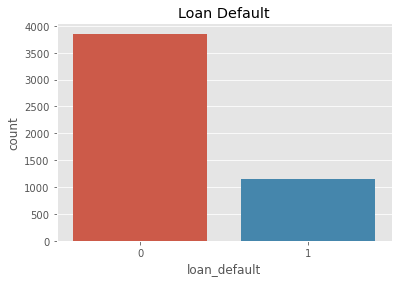

In [18]:
sns.countplot(x='loan_default', data = Data)
plt.title("Loan Default")

In [19]:
Data['loan_default'].value_counts()

0    3853
1    1147
Name: loan_default, dtype: int64

In [20]:
Data['loan_default'].mean()

0.2294

Vemos que alrededor del 20 al 25 por ciento de todos los préstamos en el conjunto de datos incumplieron.

#### 1.2 

Trace un histograma de los ingresos anuales.

**Respuesta.** A continuación se ofrece una posible solución:

Text(0.5, 0, 'Annual Income')

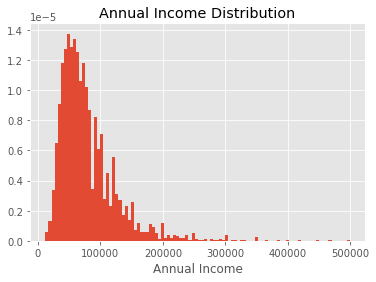

In [21]:
Data.annual_inc.hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

Vemos que los datos están bastante sesgados. Probemos una transformación logarítmica para que los datos se distribuyan más normalmente:

Text(0.5, 0, 'Annual Income')

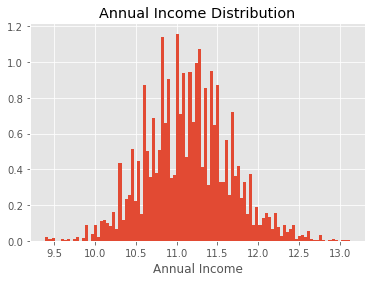

In [22]:
np.log(Data.annual_inc).hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

#### 1.3

¿La distribución de los ingresos anuales es diferente entre los solicitantes que no pagaron y los solicitantes que no incumplieron con sus préstamos?

**Respuesta.** A continuación se ofrece una posible solución:

Text(0.5, 1.0, 'Annual Salary -- Loan Status')

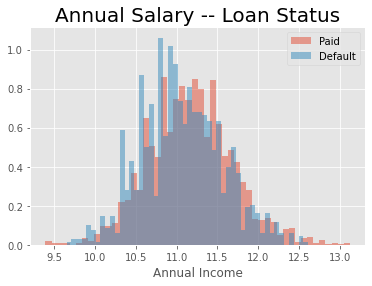

In [23]:
np.log(Data['annual_inc'][Data.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label="Paid")
np.log(Data['annual_inc'][Data.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("Annual Income")
plt.legend()
plt.title("Annual Salary -- Loan Status", fontsize=20)

Podemos ver que las distribuciones no son tan diferentes, lo que indica que los ingresos por sí solos no explican una fracción significativa de la diferencia en el estado de incumplimiento de préstamo.

#### 1.4

Explore la asociación entre el ingreso anual y la cuota mensual.

**Respuesta.** Una posible solución es la siguiente:

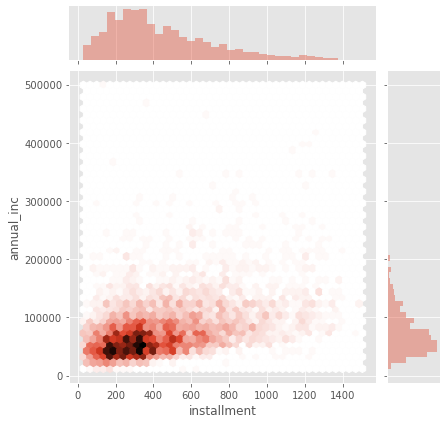

In [24]:
sns.jointplot(Data.installment, Data.annual_inc, kind="hex")

Esto muestra que las distribuciones para ambas variables están sesgadas de manera similar. Esto significa que ambos deben someterse a una transformación de registro:

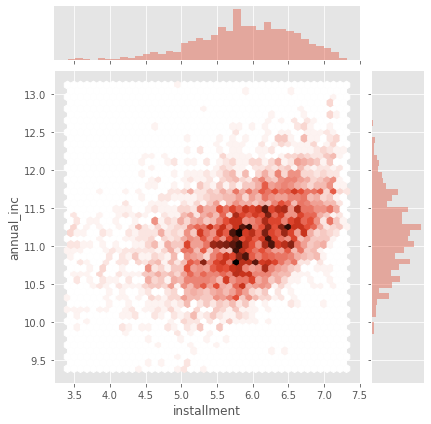

In [25]:
sns.jointplot(np.log(Data.installment), np.log(Data.annual_inc), kind="hex")

Esto se ve mucho mejor y parece sugerir (con algunos valores atípicos en el extremo izquierdo) una relación lineal entre los logaritmos de ambas variables.

Aquí hay algunas cifras más que analizan la relación entre otras covariables numéricas y la probabilidad de incumplimiento, así como el ingreso anual:

`emp_length`:

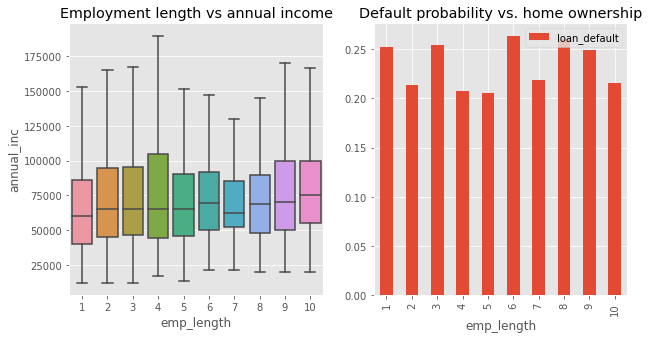

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Employment length vs annual income")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

***
___

(array([ 749.,  473.,  468.,  342.,  316.,  266.,  178.,  200.,  217.,
        1791.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

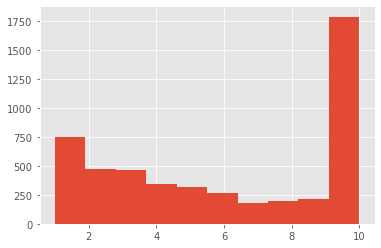

In [27]:
plt.hist(Data['emp_length'])

Text(0.5, 1.0, 'emp_length -- Loan Status')

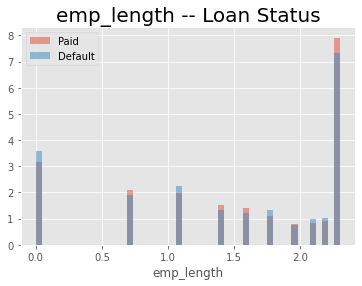

In [28]:
np.log(Data['emp_length'][Data.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label="Paid")
np.log(Data['emp_length'][Data.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("emp_length")
plt.legend()
plt.title("emp_length -- Loan Status", fontsize=20)

***
___

`homeOwnership`:

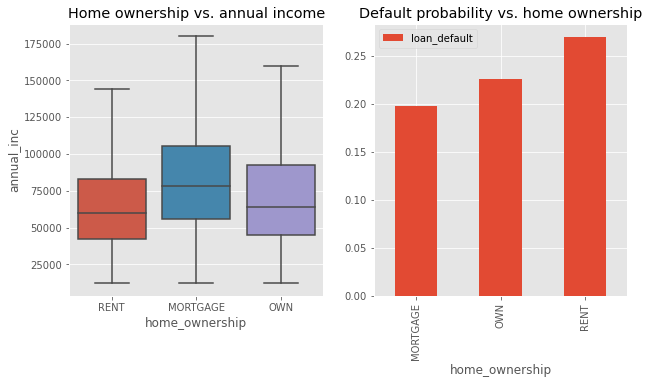

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

Aquí hay algunas cifras que muestran la relación entre varias variables categóricas y la probabilidad de incumplimiento:

`purpose`:

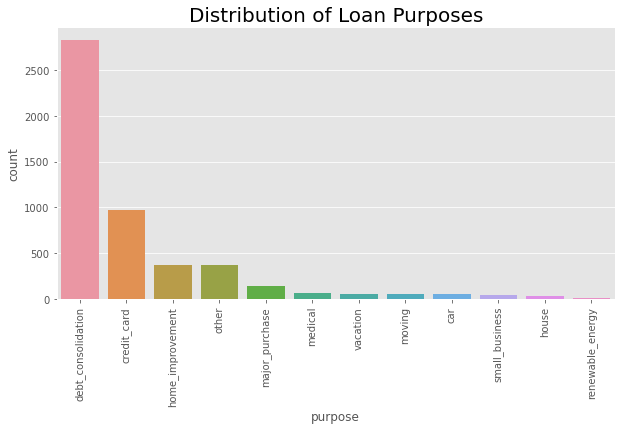

In [30]:
plt.figure(figsize= (10,5))
Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

Text(0.5, 1.0, 'Default Probability by Loan Purpose')

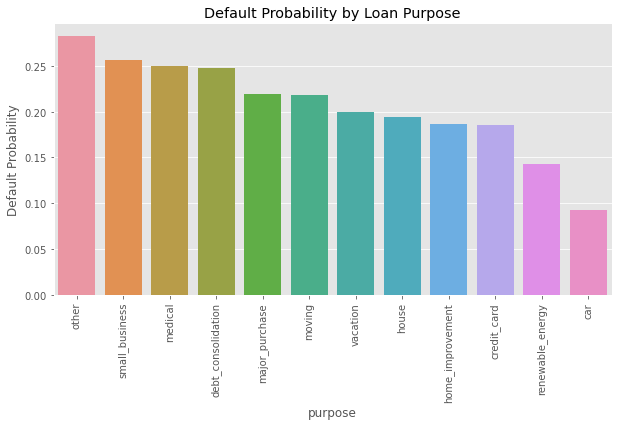

In [31]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")


`job`:

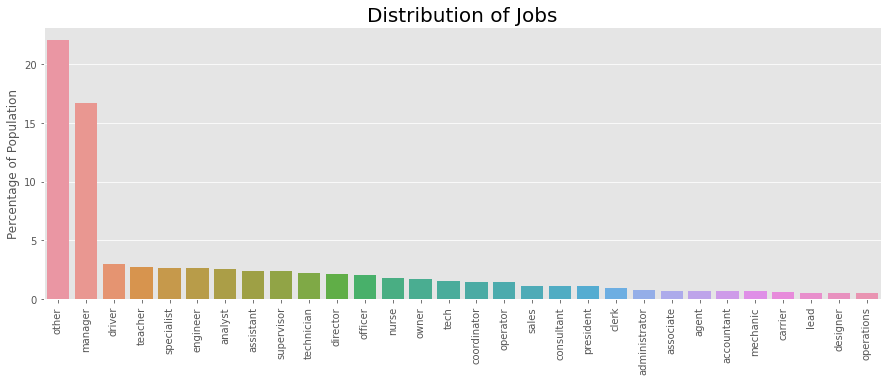

In [32]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);


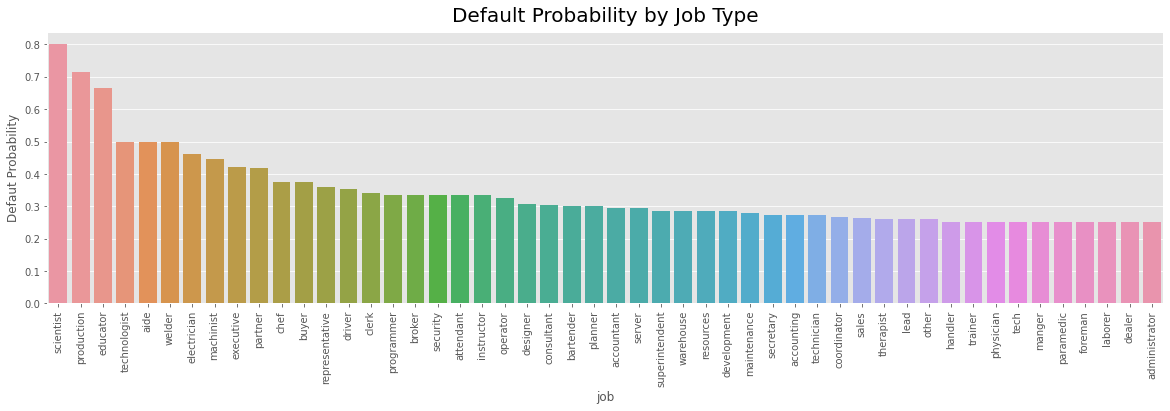

In [33]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

### Agregar una nueva variable

El pago anual adeudado por el prestatario en relación con los ingresos anuales, es una medida estándar utilizada para evaluar si se debe emitir un préstamo. Definamos una nueva variable **"install_income"** que codifica la instalación como una fracción del ingreso anual y estudie su asociación con las otras características:

Text(0.5, 0, 'Installment / Income')

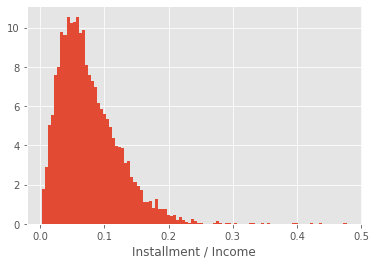

In [34]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

Para investigar fácilmente las variables asociadas con la probabilidad de incumplimiento, defina una nueva covariable llamada `install_income_disc` esa es una versión discretizada de `install_income`:

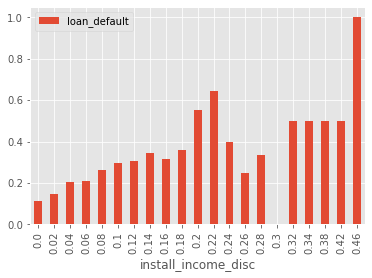

In [35]:
# discreticemos la variable "install_income" para estudiar la probabilidad de incumplimiento 
# en función de "install_income"
Data["install_income_disc"] = (Data.install_income*50).astype(int)/50.  # Discretización
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)

# --> existe una clara asociación positiva: como la fracción del ingreso anual dedicado al reembolso de
# el préstamo aumenta, la probabilidad de incumplimiento aumenta drásticamente

### Ejercicio 2

Visualice la matriz de correlación en todas las características numéricas utilizando el comando `sns.heatmap()`:

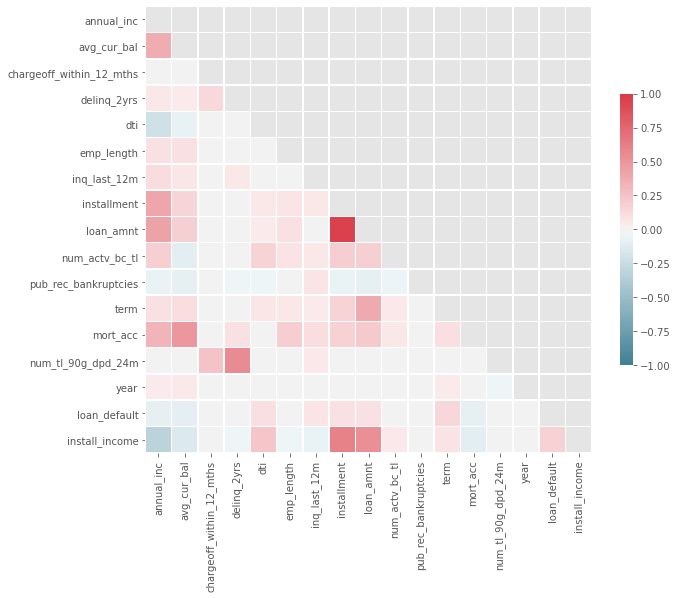

In [36]:
# Matriz de correlación
df_correlations = Data.corr()

# Enmascarar la mitad superior para fines de visualización
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Dibuje el mapa de calor con la máscara y la relación de aspecto correcta
plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Construyendo un modelo predictivo (20 mts)

Primero comencemos construyendo un modelo de regresión logística estándar. En general, es importante y extremadamente útil crear primero modelos básicos / simples que se puedan comparar con modelos más complejos más adelante.

### Ejercicio 3: (15 mts)

#### 3.1

Utilizando la función `LogisticRegression()` de `scikit-learn`, escribir una función llamada `fit_logistic_regression(X,y)` que se ajusta a una regresión logística en la matriz de covariables `X` y variable de respuesta asociada `y`.

**Respuesta.** A continuación se muestra una posible solución:

In [37]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X,y)
    return clf

#### 3.2

Cree un modelo básico de regresión logística para predecir el incumplimiento del préstamo con una sola característica: `install_income`.  Llama a este modelo`model1`. Utilice una división de prueba de tren 70/30 de los datos.

**Respuesta.** A continuación se muestra una posible solución:

In [38]:
n_total = len(Data)
n_train = int(0.7*n_total)

X, y = Data[["install_income"]], Data.loan_default
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [39]:
model1 = fit_logistic_regression(X_train, y_train)  # fit a logistic regression
y_test_pred = model1.predict_proba(X_test)[:,1]     # make probabilistic predictions on test set

#### 3.3

Trace la curva ROC del `model1` y encuentra el área debajo de la curva.

**Respuesta.** A continuación se muestra una posible solución:

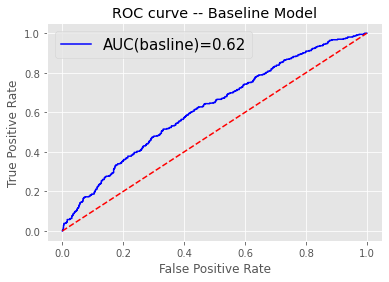

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)  #compute FPR/TPR
auc_baseline = auc(fpr, tpr) # compute AUC

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

### Ejercicio 4: (5 mts)

#### 4.1

Considere `model1` de arriba. ¿Quieres que este sea tu modelo final? ¿Por qué o por qué no?

**Respuesta.** Este no debería ser el modelo final. Esto se debe a que no hemos explorado la contribución de otras variables, que además de contener información valiosa también podría estar confundiendo el efecto percibido de `install_income` en la variable de respuesta. Esta subexplotación de la información se llama **infraajuste**.

#### 4.2

Pongamos todas las variables disponibles en el modelo, de modo que aprovechemos al máximo nuestra información disponible. ¿Estaría a favor de esto o no?

**Respuesta.** Esta también es una mala idea. Si *ciegamente* utilizamos todas las variables en nuestro ajuste del modelo, se produce un fenómeno llamado **sobreajuste**. Esto es cuando un modelo estadístico "se ajusta" demasiado a un conjunto particular de datos, que bien puede ser ruidoso y exhibir aleatoriedad y, por lo tanto, no puede predecir con fiabilidad futuras observaciones diferentes.

## Validación Cruzada (30 mts)

**La validación cruzada** es un conjunto de técnicas para evaluar qué tan bien los resultados de un modelo se generalizarán a un conjunto de datos fuera de la muestra; es decir, en la práctica o en la producción. Se utiliza principalmente para marcar el sobreajuste.

La validación cruzada funciona de la siguiente manera: uno divide los datos disponibles en conjuntos de $k$, o ** liegues**. $k - 1$ de estos pliegues se usarán para entrenar el modelo, mientras que el pliegue extendido se usará como el conjunto de prueba en el que se evalúa el modelo. Para la estabilidad computacional, este procedimiento generalmente se divide muchas veces, de modo que cada pliegue tiene la oportunidad de servir como conjunto de prueba. 

Para cada repetición, se calcula una métrica de rendimiento de predicción (por ejemplo, AUC) en el conjunto de prueba. Luego se informa el promedio de estas métricas, así como su desviación estándar. Aquí se muestra un ejemplo para la validación cruzada 5 veces:

![](cv_fig.png)

Hagamos esto con el código. El siguiente código muestra los 5 pliegues diferentes utilizados en un enfoque estándar de 5 veces de validación cruzada. Para hacerlo, use la función `StratifiedKFold ()` de `scikit-learn`:

In [33]:
y.value_counts()

0    3853
1    1147
Name: loan_default, dtype: int64

Text(0.5, 1.0, 'CROSS VALIDATION FOLDS')

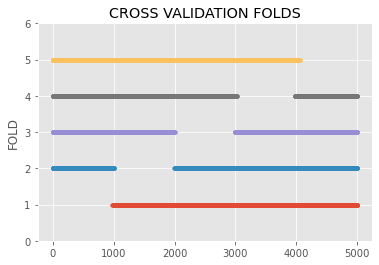

In [30]:
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

El siguiente código define una función `compute_AUC (X, y, train_index, test_index)` que calcula el AUC de un modelo entrenado en "train_index" y probado en "test_index".

In [51]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Ejercicio 5: (5 mts)

Con la ayuda de la función `compute_AUC` definida anteriormente, escriba una función`cross_validation_AUC (X, y, nfold)` que realiza una validación cruzada 10 veces y devuelve una lista que contiene el área debajo de la curva para cada pliegue de La validación cruzada.

**Respuesta.** A continuación se muestra una posible solución:

In [52]:
def cross_validation_AUC(X,y, nfold=10):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=nfold)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

In [53]:
cross_validation_AUC(X_train,y_train)

[0.6443721719457014,
 0.5506221719457014,
 0.5928780165912518,
 0.6206872171945701,
 0.6165629713423831,
 0.6514187405731523,
 0.6485671191553545,
 0.5686274509803921,
 0.6698351160726796,
 0.579172310710449]

Ahora calcularemos y compararemos, a través del análisis de validación cruzada, el rendimiento de todos los "modelos simples" que solo usan una característica numérica como entrada. Como se discutió en la sección EDA, usaremos la transformación logarítmica para las variables `anual_income`,` loan_amount` y `avg_cur_bal`:

In [0]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Using a log scale when appropriate
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Calculemos las estimaciones de validación cruzada del AUC para cada modelo de función única:

In [0]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

### Ejercicio 6: (5 mts)

Construya un diagrama de caja que muestre la distribución de los puntajes de validación cruzada de cada variable (recuerde, cada variable tiene 10 puntajes totales). ¿Qué característica tiene el poder predictivo más alto / más bajo?

**Respuesta.** A continuación se muestra una posible solución:

In [0]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

Text(0, 0.5, 'AUC')

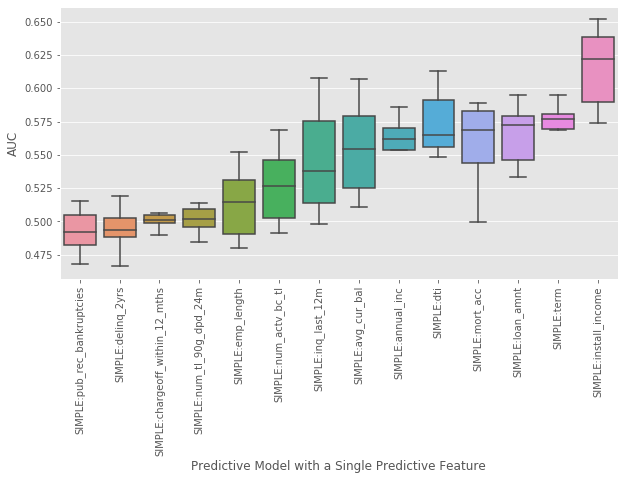

In [0]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

### Ejercicio 7:

Considere el modelo que consiste en usar * todas * las características numéricas (y ninguna de las características categóricas). Realice un análisis de validación cruzada de 10 veces para determinar si este modelo tiene un mejor rendimiento predictivo que el mejor modelo de una sola característica. Use el método boxplot nuevamente como lo hicimos en el Ejercicio 7.

**Respuesta.** A continuación se muestra una posible solución:

In [0]:
X_full, y_full = Data_numerics.drop(["loan_default"], axis=1), Data_numerics.loan_default
auc_list = cross_validation_AUC(X_full, y_full)
model_perf["ALL_NUMERICAL"] = auc_list
model_perf

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income,ALL_NUMERICAL
0,0.569362,0.545393,0.499099,0.498355,0.612818,0.487700,0.512120,0.485425,0.549403,0.515139,0.530784,0.574285,0.497263,0.573958,0.618991
1,0.569903,0.607209,0.491304,0.518732,0.565386,0.479815,0.509946,0.584062,0.553909,0.507952,0.577225,0.583780,0.511478,0.645416,0.678013
2,0.504776,0.523868,0.503435,0.500338,0.548040,0.552399,0.577349,0.572156,0.500631,0.484535,0.569453,0.557051,0.500788,0.583904,0.634332
3,0.594568,0.583783,0.498250,0.507352,0.589509,0.516194,0.598419,0.533179,0.535573,0.495110,0.576510,0.539040,0.511350,0.615912,0.694704
4,0.554376,0.581762,0.489554,0.488120,0.555573,0.513066,0.517448,0.580553,0.501558,0.481536,0.580011,0.586629,0.504020,0.627962,0.674602
5,0.529249,0.569848,0.499560,0.466121,0.555720,0.549904,0.607849,0.569949,0.523557,0.467916,0.580407,0.588922,0.514060,0.587645,0.678554
6,0.586008,0.562891,0.505195,0.487883,0.553586,0.525353,0.498148,0.572513,0.505353,0.488809,0.595200,0.579932,0.495517,0.641287,0.679119
7,0.553566,0.510492,0.502597,0.503281,0.612474,0.500353,0.536067,0.575985,0.568751,0.497448,0.589895,0.499613,0.502483,0.630371,0.655183
8,0.568364,0.516951,0.505195,0.488574,0.565026,0.533094,0.568341,0.538585,0.491479,0.469105,0.546206,0.539451,0.484154,0.595181,0.618592
9,0.555081,0.527820,0.506494,0.472306,0.591969,0.485771,0.539155,0.594577,0.529916,0.507439,0.568945,0.563044,0.494304,0.651754,0.670130


Text(0, 0.5, 'AUC')

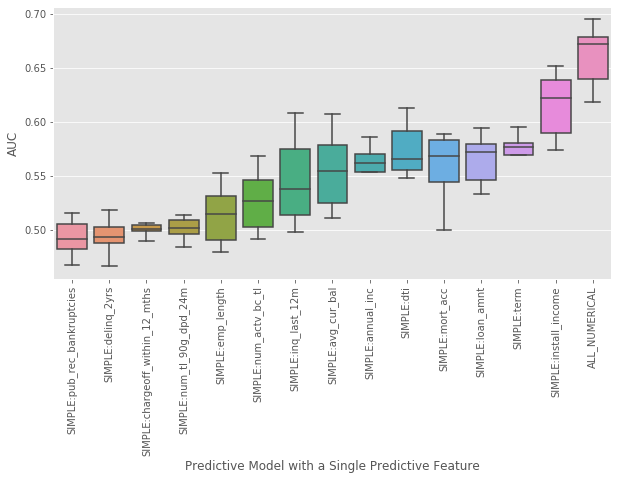

In [0]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

Vemos que el modelo combinado funciona mejor que el mejor modelo de función única. Por lo tanto, avanzaremos con él por el resto de este caso. Sin embargo, tenga en cuenta que la mejor práctica implicaría agregar iterativamente características al mejor modelo de característica única hasta que lleguemos a un punto en el que no haya una mejora significativa, en lugar de incluir todas las características a la vez. Le recomendamos que tome este enfoque más cauteloso cuando construya sus propios modelos.

## Incorporando variables categóricas (25 mts)

La calificación de un préstamo (es decir, la función de calificación de préstamo asignada por LC) no se ha utilizado hasta ahora. La siguiente es la distribución de la característica de calificación categórica:

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

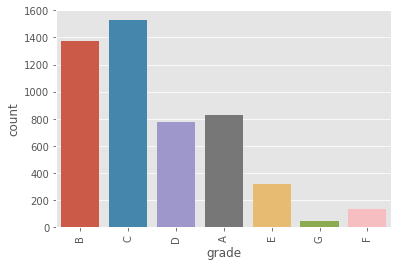

In [0]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

### Ejercicio 8: (5 mts)

#### 8.1

Use `pandas.get_dummies ()` para transformar esto en su versión codificada en caliente.

**Respuesta.** A continuación se muestra una posible solución:

In [0]:
#use a one-hot-encoding approach for incorporating the "grade" categorical variable
grade_categ = pd.get_dummies(Data['grade'], prefix = "grade", drop_first=True)
grade_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
3394,1,0,0,0,0,0
3206,0,1,0,0,0,0
4462,0,1,0,0,0,0
1093,0,0,1,0,0,0
1555,0,0,0,0,0,0


#### 8.2

Agregue esta característica al modelo totalmente numérico de antes e investigue si esto conduce a un aumento significativo en la precisión predictiva.

**Respuesta.** A continuación se muestra una posible solución:

In [0]:
X_grade = pd.concat([X_full,grade_categ],axis=1) 
X_grade.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
3394,5.161368,3.611511,0.0,0.0,6.21,10,4.0,4.103804,1.0,2.0,36,0.0,0.0,0.033791,1,0,0,0,0,0
3206,5.000000,3.700444,0.0,2.0,30.07,1,0.0,3.885078,4.0,0.0,36,0.0,0.0,0.030587,0,1,0,0,0,0
4462,4.698970,3.253580,0.0,0.0,16.19,6,3.0,4.158362,6.0,0.0,36,0.0,0.0,0.116098,0,1,0,0,0,0
1093,4.875061,4.068297,0.0,1.0,37.70,6,4.0,4.176091,3.0,0.0,36,0.0,0.0,0.088619,0,0,1,0,0,0
1555,4.929419,4.352665,0.0,0.0,24.87,4,4.0,4.000000,1.0,0.0,36,2.0,0.0,0.042515,0,0,0,0,0,0


In [0]:
auc_list = cross_validation_AUC(X_grade, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE"] = auc_list

Text(0, 0.5, 'AUC')

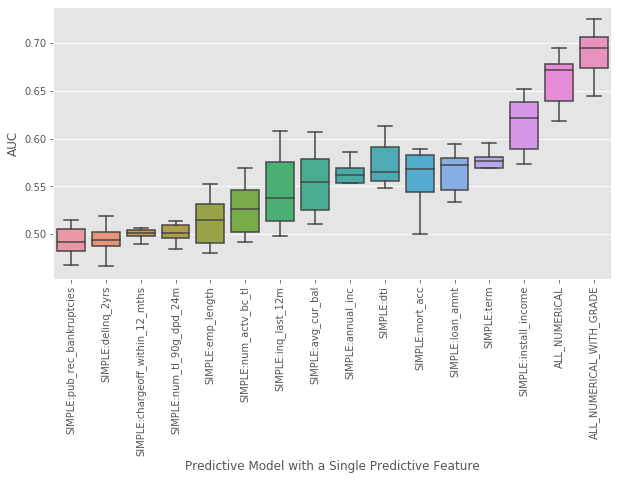

In [0]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

La diferencia parece significativa ya que el diagrama de caja para el modelo actualizado no se superpone casi por completo con el del modelo anterior.

### Ejercicio 9: (15 mts)

Investigue si la variable categórica `trabajo` aporta algún valor predictivo cuando se agrega al mejor modelo actual. De nuevo, es posible que desee utilizar un esquema de codificación de un solo uso.

**Respuesta.** A continuación se muestra una posible solución:

Text(0.5, 1.0, 'Default Rate per Employment Type')

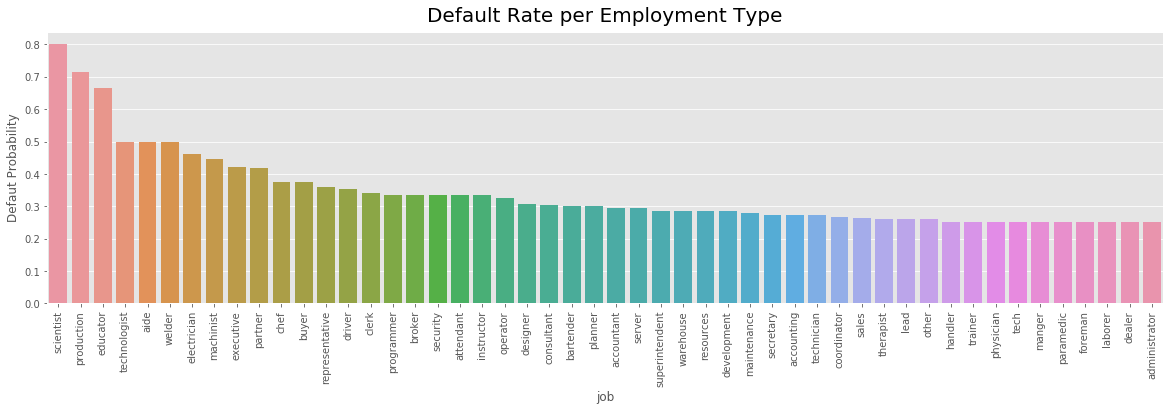

In [0]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Rate per Employment Type", fontsize=20, verticalalignment='bottom')


In [0]:
#use a one-hot-encoding approach for incorporating the "purpose" categorical variable
job_categ = pd.get_dummies(Data['job'], prefix = "job", drop_first=True)

In [0]:
X_grade_job = pd.concat([X_grade,job_categ],axis=1) 
X_grade_job.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker
3394,5.161368,3.611511,0.0,0.0,6.21,10,4.0,4.103804,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3206,5.000000,3.700444,0.0,2.0,30.07,1,0.0,3.885078,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4462,4.698970,3.253580,0.0,0.0,16.19,6,3.0,4.158362,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1093,4.875061,4.068297,0.0,1.0,37.70,6,4.0,4.176091,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1555,4.929419,4.352665,0.0,0.0,24.87,4,4.0,4.000000,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
X_grade_job.keys()
# --> 138 features

Index(['annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_2yrs',
       'dti', 'emp_length', 'inq_last_12m', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies',
       ...
       'job_technician', 'job_technologist', 'job_teller', 'job_therapist',
       'job_trainer', 'job_underwriter', 'job_vp', 'job_warehouse',
       'job_welder', 'job_worker'],
      dtype='object', length=138)

In [0]:
auc_list = cross_validation_AUC(X_grade_job, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE_JOB"] = auc_list

Text(0, 0.5, 'AUC')

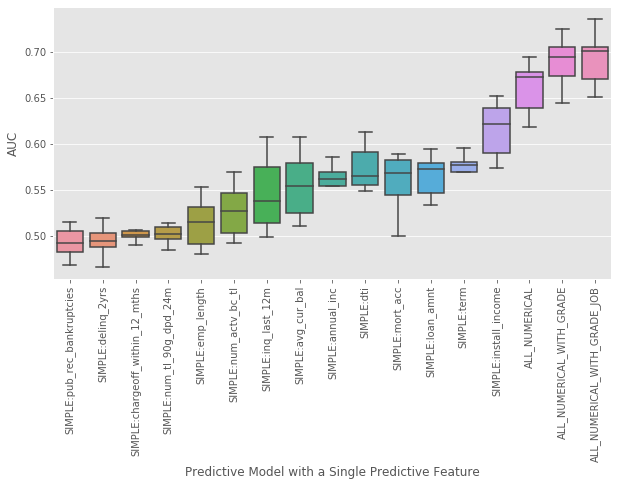

In [0]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

Podemos ver que las gráficas de caja se superponen significativamente, por lo que no hay un beneficio apreciable. Podemos repetir este proceso con otras variables categóricas para construir iterativamente el modelo más simple posible.

## Conclusiones (5 mts)

En este caso, primero exploramos el conjunto de datos del préstamo y encontramos las asociaciones de una sola variable entre las características disponibles y la tasa de incumplimiento. También descubrimos qué características requerían transformaciones (por ejemplo, transformación de registro). Una vez que comenzamos a construir modelos, comenzamos con enfoques de regresiones logísticas muy simples: estos modelos de referencia fueron útiles para evaluar rápidamente el poder predictivo de cada variable individual. Luego, empleamos enfoques de validación cruzada para construir modelos más complejos, a menudo explotando las interacciones entre las diferentes características. Dado que el conjunto de datos del préstamo contiene una gran cantidad de covariables, se demostró que el uso de la validación cruzada es crucial para evitar el sobreajuste, elegir la cantidad correcta de características y, en última instancia, elegir un modelo apropiado que equilibre la complejidad con la precisión.

## Para finalizar (5 mts)

La validación cruzada es una técnica robusta y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en configuraciones de big data donde el número de características es grande en comparación con el número de observaciones. Cuando se usa adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo.